# Gas Boiler to heat pump dynamic Material Flow analysis
This doc uses the dynamic_stock_model package

The objective is to replace every boiler by heat pumps by 2050 in Vaud Canton

## Import data

In [1]:
import dynamic_stock_model as dsm 
import copy
import numpy as np
import matplotlib.pyplot as plt
import openpyxl


In [2]:
# Vaud number housing
housing_2024= 381144

# increase of the number of housing

housing_increase_2024 = 1/100 # 1/100 is the actual rate

# Proportion of HP
prop_HP_2024 = 0.17
# Proportion of GB
prop_GB_2024 = 0.30

# Lifetime HP
lifetime_HP_2024 = [20]*(61)  # from 2015 to 2050

# Lifetime GB
lifetime_GB_2024 = [20]*(46)  # from 2015 to 2050

# std lifetime 
std_GB=0.25
std_HP=0.25

# density functions
HP_pdf='Normal'
GB_pdf='Normal'

# Define time range
Years = np.arange(2015, 2051) # 2015 to 2025 is the initialisation then 2025 to 2050 is the projection



In [3]:

def polyfit_fixed_last_point(x, y, degree=2):
    """
    Fits a polynomial of a given degree to data, forcing it through the last point.
    """
    # Define the fixed point (last point in the dataset)
    xf, yf = x[-1], y[-1]
    
    # Create the new variables
    y_prime = y - yf
    
    # Construct the design matrix for the new linear system
    # For a 2nd degree polynomial, columns are (x - xf) and (x^2 - xf^2)
    X_prime = np.vstack([x**i - xf**i for i in range(1, degree + 1)]).T
    
    # Solve the linear system for coefficients (a1, a2, ...)
    # np.linalg.lstsq solves A @ b = y for b (here, X_prime @ a_prime = y_prime)
    a_prime, residuals, rank, singular_values = np.linalg.lstsq(X_prime, y_prime, rcond=None)
    
    # Calculate a0 using the constraint equation
    a0 = yf - sum(coeff * (xf**i) for i, coeff in enumerate(a_prime, 1))
    
    # Combine coefficients into the standard order (a2, a1, a0) for np.poly1d
    # Note: np.poly1d expects [a_deg, a_deg-1, ..., a0]
    coeffs_standard_order = np.insert(a_prime, 0, a0)[::-1]
    
    return np.poly1d(coeffs_standard_order), a0, a_prime

## Initial parameters


[6180.713513513513, 6180.713513513513, 6180.713513513513, 6180.713513513513, 6180.713513513513, 6180.713513513513, 6180.713513513513, 6180.713513513513, 6180.713513513513, 6180.713513513513, 6180.713513513513, 6180.713513513513, 6180.713513513513, 6180.713513513513, 6180.713513513513, 6180.713513513513, 6180.713513513513, 6180.713513513513, 6180.713513513513, 6180.713513513513, 6180.713513513513, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 47


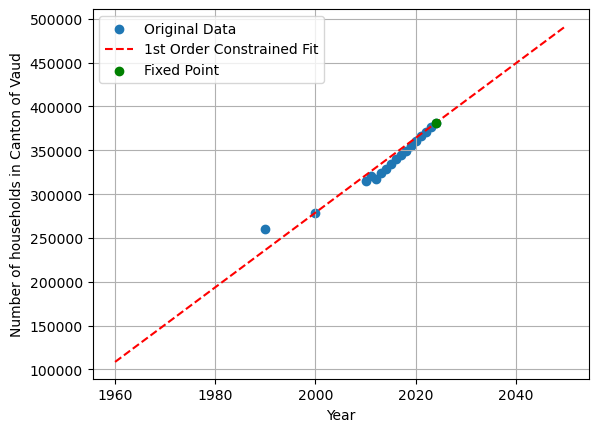

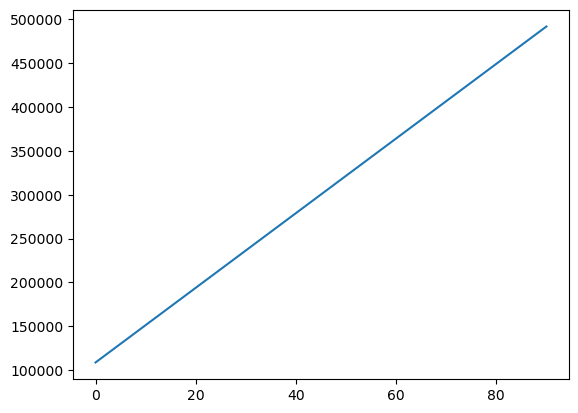

In [4]:
# Use previous import of GB sales in Vaud
GB_sales =[housing_2024*prop_GB_2024/18.5]*21+[0]*26
print(GB_sales, len(GB_sales))

# Calculate housing increase over time for future years
Dates_housing=[1990, 2000, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Housing_data=[260060, 278752, 314596, 321158, 317243, 323577, 328414,333955,339882, 344627, 349758, 354496, 360928, 366389, 370394, 376518, housing_2024]

# --- Usage ---
# Sample data
x = np.array(Dates_housing)
y = np.array(Housing_data)

# Perform the constrained fit
polynomial_func, a0, a_prime = polyfit_fixed_last_point(x, y, degree=1)

# Generate points for plotting the curve
x_new = np.arange(1960, 2051)
y_fit = polynomial_func(x_new)

# Plotting
plt.scatter(x, y, label='Original Data')
plt.plot(x_new, y_fit, '--',color='red', label='1st Order Constrained Fit')
plt.scatter(x[-1], y[-1], color='green', zorder=5, label='Fixed Point') # Highlight fixed point
plt.xlabel('Year')
plt.ylabel('Number of households in Canton of Vaud')
#plt.title('First order regression for housing increase')
plt.legend()
plt.grid(True)
plt.show()



Housing=y_fit.tolist()
plt.plot(Housing)

## Create the models

114343.2
output flow [0.00000000e+00 3.60888062e-01 1.11728617e+00 2.64048490e+00
 5.58755813e+00 1.10659552e+01 2.08505829e+01 3.76410712e+01
 6.53239064e+01 1.09175566e+02 1.75916105e+02 2.73509767e+02
 4.10623747e+02 5.95708261e+02 8.35749936e+02 1.13486028e+03
 1.49296038e+03 1.90487354e+03 2.36010799e+03 2.84349256e+03
 3.33664215e+03 3.82002672e+03 4.27490028e+03 4.68605704e+03
 5.04263394e+03 5.33879722e+03 5.57336049e+03 5.74866038e+03
 5.86898387e+03 5.93889470e+03 5.96178358e+03 5.93889470e+03
 5.86898387e+03 5.74866038e+03 5.57336049e+03 5.33879722e+03
 5.04263394e+03 4.68605704e+03 4.27490028e+03 3.82002672e+03
 3.33680758e+03 2.84373086e+03 2.36037712e+03 1.90515520e+03
 1.49324694e+03 1.13514868e+03 8.36038997e+02]
114176.77576701486


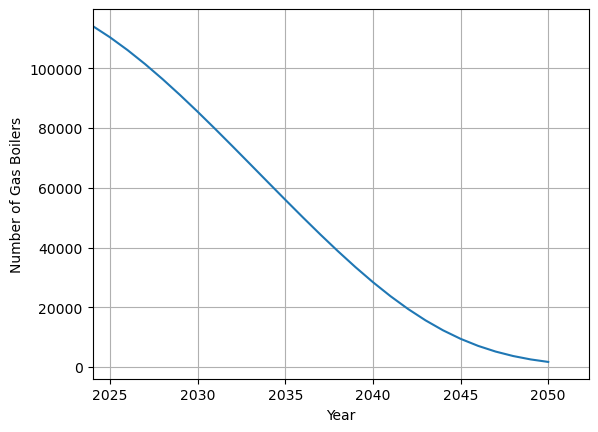

273.50976683036697


In [5]:
# inflow driven model for Gas boilers
# over 2004-2024 and then projection 2025-2050
Years_GB=np.arange(2004,2051)
GB_DSM = dsm.DynamicStockModel(t = Years_GB, 
                               i =GB_sales, lt = {'Type': GB_pdf, 'Mean': lifetime_GB_2024, 'StdDev': std_GB* np.array(lifetime_GB_2024)},)

print(housing_2024*prop_GB_2024)

# compute stock
S_C, O_C= GB_DSM.compute_s_c_inflow_driven()
O_C= GB_DSM.compute_o_c_from_s_c()

S=GB_DSM.compute_stock_total()
O=GB_DSM.compute_outflow_total()
check_GB=GB_DSM.dimension_check()
print("output flow", GB_DSM.o)

# plot stock
print(GB_DSM.s.max())
plt.grid()
plt.plot( GB_DSM.t,GB_DSM.s, label='Gas Boilers Stock')
#plt.title('Gas Boilers Stock over time')
plt.xlabel('Year')
plt.ylabel('Number of Gas Boilers')
plt.xlim(2024)
#plt.hlines(housing_2024*prop_GB_2024,xmin=2000, xmax=2024, color='red', linestyles='dashed', label='2024 GB Stock Target')
#plt.legend(loc='lower right')
plt.show()
print(GB_DSM.o[11])


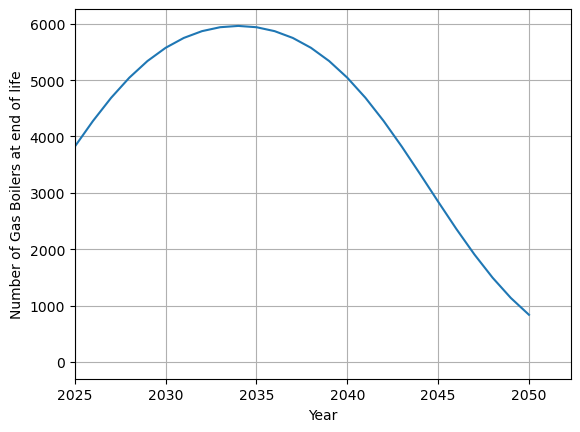

In [6]:
# plot stock

plt.grid()
plt.plot( GB_DSM.t,GB_DSM.o, label='Gas Boilers Stock')
#plt.title('Gas Boilers exports over time')
plt.xlabel('Year')
plt.xlim(2025)
plt.ylabel('Number of Gas Boilers at end of life')
plt.show()

35


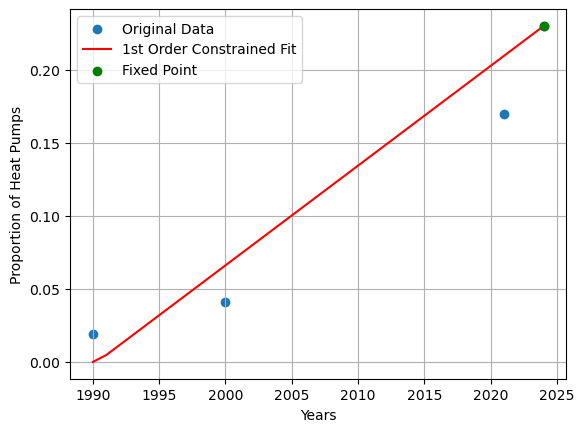

In [7]:
# Model for the heat pumps STOCK driven model
# past stock


Years_HP=np.arange(1990, 2025)
Data_past=[1990, 2000, 2021, 2024]
Data_past_HP=[1.9/100, 4.1/100, 17/100, 23/100]




# --- Usage ---
# Sample data
x = np.array(Data_past)
y = np.array(Data_past_HP)

# Perform the constrained fit
polynomial_func, a0, a_prime = polyfit_fixed_last_point(x, y, degree=1)

# Generate points for plotting the curve
x_new = Years_HP
y_fit = polynomial_func(x_new)
print(len(y_fit))
# Plotting
plt.scatter(x, y, label='Original Data')
plt.plot(x_new, y_fit.clip(min=0), color='red', label='1st Order Constrained Fit')
plt.scatter(x[-1], y[-1], color='green', zorder=5, label='Fixed Point') # Highlight fixed point
plt.xlabel('Years')
plt.ylabel('Proportion of Heat Pumps')
#plt.title('First Order Polynomial Regression Forcing Last Point')
plt.legend()
plt.grid(True)
plt.show()

# Print coefficients
# print(f"Coefficients (a0, a1, a2): {a0}, {a_prime[0]}, {a_prime[1]}")
# print(f"Function: {polynomial_func}")


HP_stock_i=[x*h for x,h in zip(y_fit.clip(min=0).tolist(),Housing)]

In [8]:
# from 2025 to 2050
H=[HP_stock_i[-1]]*(2050-2024) #63651
Housing_increase=[h-housing_2024 for h in Housing]

GB_to_HP=np.array(GB_DSM.o).cumsum()

HP_stock_f = [a + b + (prop_GB_2024+prop_HP_2024)*hi for a,b,hi in zip(H,GB_to_HP,Housing_increase[-(2050-2024):])]  #  2025 to 2050 is the projection

# total stock
HP_stock= HP_stock_i + HP_stock_f

# add new DSM for heat pumps

HP_DSM = dsm.DynamicStockModel(t = np.arange(1990,2051), 
                               s =HP_stock, lt = {'Type': HP_pdf, 'Mean': lifetime_HP_2024, 'StdDev': std_HP* np.array(lifetime_HP_2024)},)

('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 61 years.<br>Inflow is not present.<br>Total stock is present with 61 years.<br>Stock by cohorts is not present.<br>Total outflow is not present.<br>Outflow by cohorts is not present.<br>Lifetime distribution is present with type Normal and mean [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20].<br>', 1)


Text(0, 0.5, '% of Heat pumps')

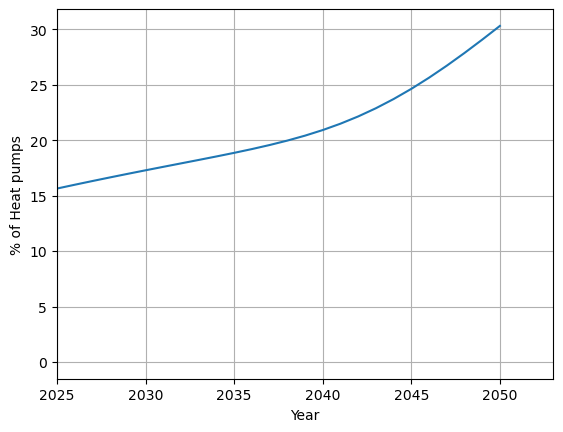

In [9]:
# compute stock driven model to get inflow
check_HP=HP_DSM.dimension_check()
print(check_HP)
I_C1= HP_DSM.compute_stock_driven_model()

S1=HP_DSM.compute_stock_total()

O1=HP_DSM.compute_outflow_total()
# plot stock

plt.grid()
plt.plot( HP_DSM.t,np.array(HP_DSM.s)/(Housing[30:])*100, label='Heat pump Stock') #[-16] for 2035
#plt.title('Heat pump Stock over time (% of housing in 2035)')
plt.xlabel('Year')
#plt.hlines(50,xmin=2000, xmax=2050, color='red', linestyles='dashed', label='50% Target for 2035')
plt.xlim(2025)
plt.ylabel('% of Heat pumps')

Text(0, 0.5, 'Heat pumps')

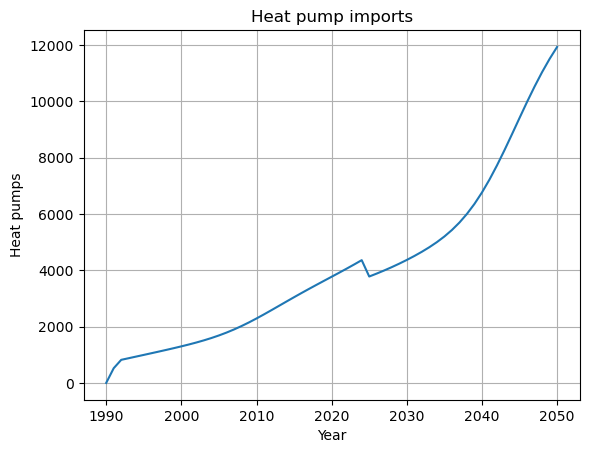

In [10]:
# plot stock

plt.grid()
plt.plot( HP_DSM.t,HP_DSM.i, label='Heat pump import')
plt.title('Heat pump imports')
plt.xlabel('Year')
plt.ylabel('Heat pumps')

## Calculating an incentive to buy HP 
Target of 55% in 2035(from https://www.sciencedirect.com/science/article/pii/S0301421525002253)

[60285.106931198105, 62286.66006534661, 64288.9695976008, 66292.80232858822, 68299.5821328085, 70311.84033410354, 72333.88316311061, 74372.71648041694, 76439.23263292768, 78549.60044451665, 80726.70879537276, 83001.41080828974, 85413.22680157342, 88010.1273088969, 90847.06949105451, 93983.12201859413, 97477.27464511449, 101383.34043286054, 105744.64066716585, 110589.32547407414, 115927.15986970022, 121748.37883792925, 128024.47136465568, 134711.7206545021, 141755.546844596, 149095.53630683915]
64572.017062977706


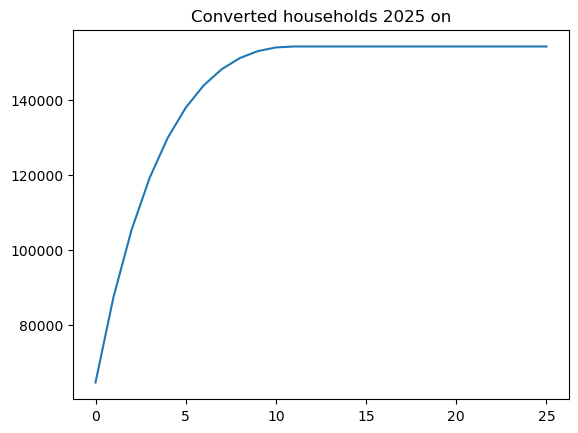

In [11]:
incentive_HP=20/100 #<- result: percentage of households that don't have converted yet but will convert due to incentives

# calculate converted households
Converted_households=[incentive_HP*(housing_2024-HP_stock_i[-1])]

for i in range(1,26):
    Converted_households.append(max(incentive_HP*(Housing[26-i]-HP_stock[26-i]-Converted_households[-1])+Converted_households[-1],Converted_households[-1]))
plt.plot(Converted_households)
plt.title("Converted households 2025 on")

HP_stock_f1 = [a+ b for a,b in zip(HP_DSM.s[-26:],Converted_households)]
print(HP_DSM.s[-26:])
print(Converted_households[0])



124857.12399417581


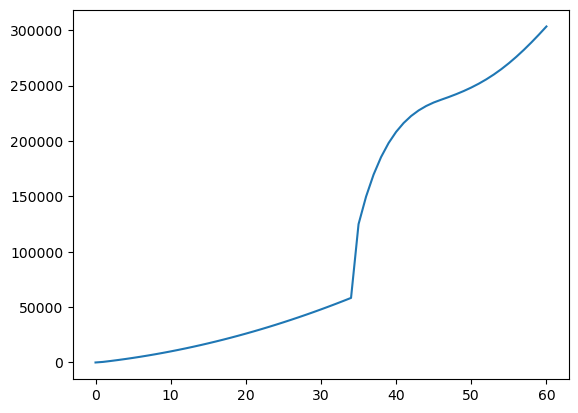

In [12]:

# total stock
HP_stock1= HP_stock_i + HP_stock_f1
print(HP_stock_f1[0])
plt.plot(HP_stock1)

# add new buildings

HP_DSM_incentive = dsm.DynamicStockModel(t = np.arange(1990, 2051), 
                               s =HP_stock1, lt = {'Type': HP_pdf, 'Mean': lifetime_HP_2024, 'StdDev': std_HP* np.array(lifetime_HP_2024)},)

54.829267286375114


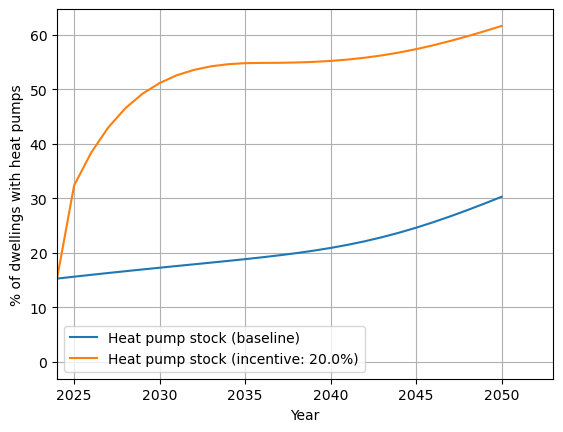

In [13]:
# compute stock driven model to get inflow (si pas déjà fait avant)
HP_inc = HP_DSM_incentive.compute_stock_driven_model()
S_inc  = HP_DSM_incentive.compute_stock_total()
O_inc  = HP_DSM_incentive.compute_outflow_total()
check_HP_inc = HP_DSM_incentive.dimension_check()

Housing_array = np.array(Housing)  # same lenght que HP_DSM.t = 1990–2050

# plot stock

plt.grid()
plt.plot(HP_DSM.t,100 * np.array(HP_DSM.s) / Housing_array[30:],label='Heat pump stock (baseline)')
plt.plot(
    HP_DSM_incentive.t,100 * np.array(HP_DSM_incentive.s) / Housing_array[30:],label=f'Heat pump stock (incentive: {incentive_HP*100:.1f}%)')
#plt.title('Heat pump stock over time (% of dwellings)')
plt.xlim(2024)
plt.xlabel('Year')
plt.ylabel('% of dwellings with heat pumps')
plt.legend()
print(np.array(HP_DSM_incentive.s)[-16]*100 / Housing_array[-16])


In [14]:
# compute stock driven model to get inflow
HP_inc= HP_DSM_incentive.compute_stock_driven_model()

S_inc=HP_DSM_incentive.compute_stock_total()
O_inc=HP_DSM_incentive.compute_outflow_total()
check_HP_inc=HP_DSM_incentive.dimension_check()

print(check_HP_inc)


('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 61 years.<br>Inflow vector is present with 61 years.<br>Total stock is present with 61 years.<br>Stock by cohorts is present with 61 years and 61 cohorts.<br>Total outflow is present with 61 years.<br>Outflow by cohorts is present with 61 years and 61 cohorts.<br>Lifetime distribution is present with type Normal and mean [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20].<br>', 1)


Text(0, 0.5, 'Heat pumps')

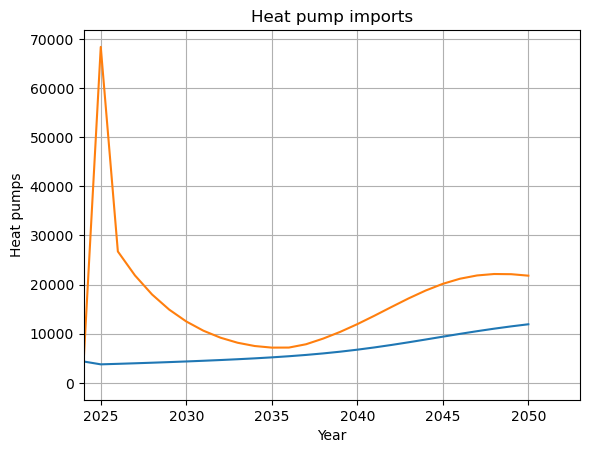

In [70]:

plt.grid()
plt.plot( HP_DSM.t,HP_DSM.i, label='Heat pump import')

plt.plot( HP_DSM_incentive.t,HP_DSM_incentive.i, label='Heat pump import with incentive')
plt.title('Heat pump imports')
plt.xlabel('Year')
plt.xlim(2024)
plt.ylabel('Heat pumps')

# Flow modelling:
electricity import,
gas import,
CO2 emissions,
Copper use, copper waste

In [15]:
# Data

# Household energy consumption
S_household=95 #m2 de surface habitable average
cons_surface=30 #kWh/m² per year

#Household energy consumption 
E_household = S_household * cons_surface    #2850 kWh per year
print(E_household)

# Heat pump
COP=3.26 # Coefficient of performance
SCOP = 3.6 # seasonal coefficient of performance

# Correct gas calculation

# 1. Household heat demand
E_household = 2850  # kWh/year

# 2. Gas properties
LHV_kWh = 50 * 0.278  # 13.9 kWh/kg
efficiency_GB = 0.9
e_gas_MJ = 0.0754  # kg CO₂/MJ

# 3. Gas consumption (kg/year)
gas_need_GB = E_household / (efficiency_GB * LHV_kWh)

# 4. CO₂ per kg gas
co2_per_kg_gas = 50 * e_gas_MJ  # MJ/kg * kgCO2/MJ = kgCO2/kg

# 5. Annual emissions
co2_gasboiler = gas_need_GB * co2_per_kg_gas # kgco2/year

print("Gas needed:", gas_need_GB, "kg/year")
print("CO₂ from gas boiler:", co2_gasboiler, "kg/year")

# emissions
e_elec= 0.0273 #kgCO2/kWh
e_HP_manufacture=1010+81-175 #kgCO2/unit (assembly+transport+End of Life)

print(e_HP_manufacture,"Co2 for manufacturing + "  , E_household * e_elec, "kg Co2 per year") 
# Copper
copper_HP= 25 #kg
copper_GB= 1.5 #kg
# electricity needs per household

elec_need_HP= S_household*cons_surface/COP  #kWh/year

# electricity needs total per year
Elec_imports=np.array(HP_DSM.s)*elec_need_HP/1000000  #GWh/year
Elec_imports_inc=np.array(HP_DSM_incentive.s)*elec_need_HP/1000000  #GWh/year

# gas needs total per year
Gas_imports=np.array(GB_DSM.s[20:])*gas_need_GB/1000000  #kt/year

print("Emissions 2025 from gassboilers: ", 114000 * co2_gasboiler/1e3, "t Co2" )
print("Emissions Heat pump 2025: ", ((e_HP_manufacture + E_household * e_elec) * 380000*0.17)/1e3, " t Co2" )

2850
Gas needed: 227.8177458033573 kg/year
CO₂ from gas boiler: 858.872901678657 kg/year
916 Co2 for manufacturing +  77.805 kg Co2 per year
Emissions 2025 from gassboilers:  97911.51079136689 t Co2
Emissions Heat pump 2025:  64199.80300000001  t Co2


## Electricity imports

In [52]:
# plot electricity imports
# plt.grid()
# plt.plot( HP_DSM.t,Elec_imports, label='Electricity imports HP')
# plt.plot( HP_DSM_incentive.t,Elec_imports_inc, label='Electricity imports HP with incentives')
# plt.title('Electricity imports for Heat pumps over time')
# plt.xlabel('Year')
# plt.xlim(2024)
# plt.ylabel('GWh/year')
# plt.legend()

## Gas imports

In [51]:
# plot gas imports
# plt.grid()
# plt.plot( GB_DSM.t[20:],Gas_imports, label='Gas imports GB')
# plt.title('Gas imports for Gas Boilers over time')
# plt.xlabel('Year')
# plt.ylabel('kt/year')
# plt.legend()

## $CO_2$ emissions
We use scope 3

In [16]:
# ---- HP EMISSIONS (corrected units) ----
# Elec_imports = GWh
# Convert to kWh: 1 GWh = 1,000,000 kWh

CO2_emissions_HP = (Elec_imports * 1_000_000 * e_elec + HP_DSM.i * e_HP_manufacture) / 1000
# result: tonnes CO2/year

CO2_emissions_HP_inc = (Elec_imports_inc * 1_000_000 * e_elec + HP_DSM_incentive.i * e_HP_manufacture) / 1000

# household heat demand
E_h = 2850  # kWh

# fuel energy needed
fuel_energy_kWh = E_h / efficiency_GB

# convert kWh -> MJ
fuel_energy_MJ = fuel_energy_kWh * 3.6

# emissions per household (kg CO2/year)
CO2_household_GB = fuel_energy_MJ * co2_gasboiler   # kg/year

# total emissions for population (kt CO₂/year)
CO2_emissions_GB = CO2_household_GB * GB_DSM.s[20:] / 1e6
print


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [17]:
# --------------------------------------------------------
# 1. Household energy demand
# --------------------------------------------------------
S_household = 95            # m² average
cons_surface = 30           # kWh/m² per year
E_household = S_household * cons_surface   # 2850 kWh per year
print(f"[DEBUG] E_household: {E_household} kWh/year")  # Debug

# --------------------------------------------------------
# 2. Gas boiler parameters
# --------------------------------------------------------
efficiency_GB = 0.9
LHV_MJ = 50                 # MJ/kg
LHV_kWh = LHV_MJ * 0.278    # → 13.9 kWh/kg
e_gas_MJ = 0.0754           # kg CO₂ per MJ burned
print(f"[DEBUG] LHV_kWh: {LHV_kWh} kWh/kg")  # Debug

# Gas needed per household
gas_need_GB = E_household / (efficiency_GB * LHV_kWh)     # kg gas/year
print(f"[DEBUG] gas_need_GB: {gas_need_GB} kg/year")  # Debug

# Emissions per kg gas
co2_per_kg_gas = LHV_MJ * e_gas_MJ                        # kg CO₂ per kg gas
print(f"[DEBUG] co2_per_kg_gas: {co2_per_kg_gas} kg CO2/kg")  # Debug

# Annual emission per household
co2_gasboiler_household = gas_need_GB * co2_per_kg_gas     # kg CO₂/year
print(f"[DEBUG] co2_gasboiler_household: {co2_gasboiler_household} kg CO2/year")  # Debug

# --------------------------------------------------------
# 3. Heat pump parameters
# --------------------------------------------------------
COP = 3.26
SCOP = 3.6
e_elec = 0.0273                 # kg CO₂ / kWh (Swiss grid)
e_HP_manufacture = 1010 + 81 - 175   # kg CO₂ per HP manufactured
print(f"[DEBUG] e_HP_manufacture: {e_HP_manufacture} kg CO2")  # Debug

# Electricity per household
elec_need_HP = E_household / SCOP
print(f"[DEBUG] elec_need_HP: {elec_need_HP} kWh/year per household")  # Debug

# --------------------------------------------------------
# 4. Imported time-series (your model)
# --------------------------------------------------------
# Electricity imports for HP (GWh)
Elec_imports = np.array(HP_DSM.s) * elec_need_HP / 1e6
Elec_imports_inc = np.array(HP_DSM_incentive.s) * elec_need_HP / 1e6

# --------------------------------------------------------
# 5. Correct annual HP emissions (tonnes CO₂/year)
# --------------------------------------------------------
CO2_emissions_HP = (Elec_imports * 1_000_000 * e_elec + HP_DSM.i * e_HP_manufacture) / 1000
CO2_emissions_HP_inc = (Elec_imports_inc * 1_000_000 * e_elec + HP_DSM_incentive.i * e_HP_manufacture) / 1000
print(f"[DEBUG] CO2_emissions_HP (t/year): {CO2_emissions_HP}")  # Debug
# print(f"[DEBUG] CO2_emissions_HP_inc (t/year): {CO2_emissions_HP_inc}")  # Debug

# --------------------------------------------------------
# 6. Correct GB emissions (tonnes CO₂/year)
# --------------------------------------------------------
CO2_emissions_GB = co2_gasboiler_household * GB_DSM.s / 1000    # t CO₂/year
print(f"[DEBUG] CO2_emissions_GB (t/year): {CO2_emissions_GB}")  # Debug

# --------------------------------------------------------
# 7. Cumulative emissions (2025–2050)
# --------------------------------------------------------
cum_HP = np.cumsum(CO2_emissions_HP)             # kt
cum_HP_inc = np.cumsum(CO2_emissions_HP_inc)     # kt
cum_GB = np.cumsum(CO2_emissions_GB)             # kt


[DEBUG] E_household: 2850 kWh/year
[DEBUG] LHV_kWh: 13.900000000000002 kWh/kg
[DEBUG] gas_need_GB: 227.8177458033573 kg/year
[DEBUG] co2_per_kg_gas: 3.7699999999999996 kg CO2/kg
[DEBUG] co2_gasboiler_household: 858.872901678657 kg CO2/year
[DEBUG] e_HP_manufacture: 916 kg CO2
[DEBUG] elec_need_HP: 791.6666666666666 kWh/year per household
[DEBUG] CO2_emissions_HP (t/year): [    0.           490.06091838   780.00175702   852.32368446
   925.98246781  1001.04877617  1077.64396607  1155.96662511
  1236.32597343  1319.17930898  1405.16735819  1495.13777433
  1590.14431475  1691.40902552  1800.23856053  1917.89419376
  2045.42720366  2183.50430737  2332.25752371  2491.19501589
  2659.20158223  2834.64014264  3015.54292934  3199.85964159
  3385.71619056  3571.63607455  3756.68709997  3940.53528944
  4123.40916063  4305.99489024  4489.29214509  4674.46073013
  4862.68171729  5055.04697686  5252.48160386  4763.90570157
  4903.20148907  5048.06711474  5198.82703341  5355.84484802
  5519.69678994

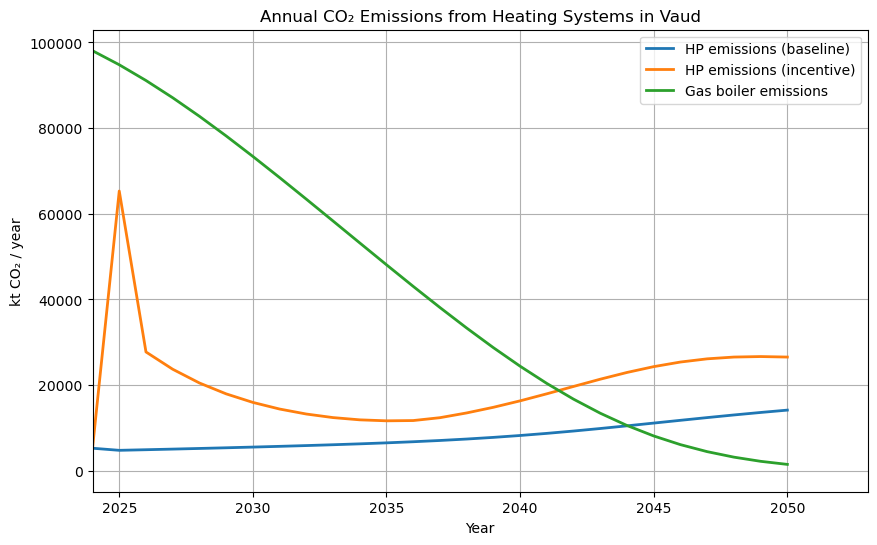

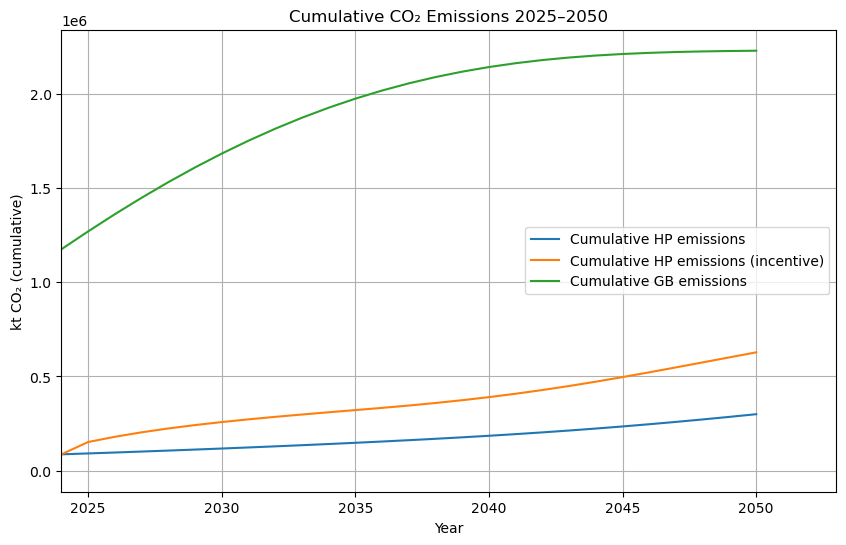

Gas boiler emissions 2025 (kt CO2): 97.9115107913669
Gas boiler from model 2025 (kt CO2): 5308.447349795838


In [18]:
# --------------------------------------------------------
# 8. PLOT — Annual emissions
# --------------------------------------------------------
plt.figure(figsize=(10,6))
plt.grid(True)

plt.plot(HP_DSM.t, CO2_emissions_HP, label="HP emissions (baseline)", linewidth=2)
plt.plot(HP_DSM_incentive.t, CO2_emissions_HP_inc, label="HP emissions (incentive)", linewidth=2)
plt.plot(GB_DSM.t, CO2_emissions_GB, label="Gas boiler emissions", linewidth=2)

plt.xlabel("Year")
plt.ylabel("kt CO₂ / year")
plt.title("Annual CO₂ Emissions from Heating Systems in Vaud")
plt.legend()
plt.xlim(2024)

plt.show()

# --------------------------------------------------------
# 9. PLOT — Cumulative emissions
# --------------------------------------------------------
plt.figure(figsize=(10,6))
plt.grid(True)

plt.plot(HP_DSM.t, cum_HP, label="Cumulative HP emissions")
plt.plot(HP_DSM_incentive.t, cum_HP_inc, label="Cumulative HP emissions (incentive)")
plt.plot(GB_DSM.t, cum_GB, label="Cumulative GB emissions")

plt.xlabel("Year")
plt.ylabel("kt CO₂ (cumulative)")
plt.title("Cumulative CO₂ Emissions 2025–2050")
plt.legend()
plt.xlim(2024)

plt.show()

# --------------------------------------------------------
# 10. PRINT 2025 sanity check
# --------------------------------------------------------
print("Gas boiler emissions 2025 (kt CO2):",
      114000 * co2_gasboiler_household / 1e6)

print("Gas boiler from model 2025 (kt CO2):",
      CO2_emissions_GB[0])


## Copper flows

GB imports :  -4884.999452783184
HP imports :  -824888.4421631785
GB exports :  3123.196371451543
HP imports :  17327.556630316547
HP stock 1507.1276732799527
GB copper stock 50.180971310277585


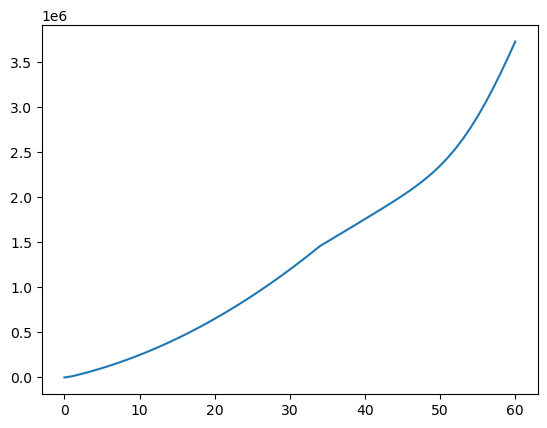

In [43]:
# recycle coefficient
k=0.61

# Copper stocks
Copper_HP_s=np.array(HP_DSM.s)*copper_HP
Copper_HP_inc_s=np.array(HP_DSM_incentive.s)*copper_HP
Copper_GB_s=np.array(GB_DSM.s)*copper_GB

# Copper exports
Copper_HP_o=(1-k)*np.array(HP_DSM.o)*copper_HP

Copper_HP_inc_o=(1-k)*np.array(HP_DSM_incentive.o)*copper_HP
Copper_GB_o=(1-k)*np.array(GB_DSM.o)*copper_GB

# Copper imports
Copper_HP_i=np.array(HP_DSM.i)*copper_HP-k*np.array(HP_DSM.s)*copper_HP
Copper_HP_inc_i=np.array(HP_DSM_incentive.i)*copper_HP-k*np.array(HP_DSM_incentive.o)*copper_HP
Copper_GB_i=np.array(GB_DSM.i)*copper_GB-k*np.array(GB_DSM.o)*copper_GB

print("GB imports : ", Copper_GB_i[35])
print("HP imports : ", Copper_HP_i[35])
print("GB exports : ", Copper_GB_o[35])
print("HP imports : ", Copper_HP_o[35])
print("HP stock", Copper_HP_s[35]/1000)
print("GB copper stock", Copper_GB_s[35]/1000)
x = np.arange(len(Copper_HP_s))

plt.plot(x,Copper_HP_s)

In [62]:
# GB copper stock: 11400 GB * 2.7kg = 307080 kg Cu = 307.8 tonn 
# # HP copper stock: 64 600 HP * 36 kg = 2 325.6 tonn 
# # HP stock is growing so increase each year is 
# # GB replacementrate + HP replacementrate + growing rate = 
# 4560 + 5000 + 440 = 10000 * 36kg = 360000 kg = 36 tonn 
# # Recycled GB = 0.61 * 4560 * 2.7kg # Recycled HP = 0.61 * 5000 * 36 kg 
# # Rest is outflow (waste)# Model values (tonnes)

#We chosse Copper_HP_s[35] as 2024 and same for GB
# We choose flow out as Copper_HP_o[35] same for GB

import plotly.graph_objects as go
import pandas as pd

rr = 0.61
hp_cu_out = Copper_HP_o[35]/1000
gb_cu_out = Copper_GB_o[35]/1000


hp_to_cu = rr * hp_cu_out
gb_to_cu = rr * gb_cu_out

imports_to_cu = -Copper_HP_i[35]/1000 +  -Copper_GB_i[35]/1000

gb_to_outflow = gb_cu_out - gb_to_cu
hp_to_outflow = hp_cu_out - hp_to_cu

cu_to_hp = imports_to_cu + gb_to_cu + hp_to_cu
# -------------------------

labels = [
    "Imports",   # 0
    "Cu Pool",   # 1
    "GB Stock (307.8 tonn)",  # 2
    "HP Stock (2325.6 tonn)",  # 3
    "Outflow"    # 4
]

sources = [
    0,  # Imports → Cu
    2,  # GB → Cu
    2,  # GB → Outflow
    1,  # Cu → HP
    3,  # HP → Cu
    3   # HP → Outflow
]

targets = [
    1,  # Imports → Cu
    1,  # GB → Cu
    4,  # GB → Outflow
    3,  # Cu → HP
    1,  # HP → Cu
    4   # HP → Outflow
]

values = [
    imports_to_cu,
    gb_to_cu,
    gb_to_outflow,
    cu_to_hp,
    hp_to_cu,
    hp_to_outflow
]

colors = [
    "rgba(0,100,255,0.6)",  # Imports → Cu
    "rgba(0,150,200,0.6)",  # GB → Cu
    "rgba(255,120,50,0.6)", # GB → Outflow
    "rgba(0,200,120,0.6)",  # Cu → HP
    "rgba(0,180,80,0.6)",   # HP → Cu
    "rgba(255,120,50,0.6)"  # HP → Outflow
]

node_x = [
    0.00,  # Imports
    0.30,  # Cu Pool
    0.60,  # GB Stock
    0.75,  # HP Stock
    0.95   # Outflow
]

node_y = [
    0.50,  # Imports (center left)
    0.50,  # Cu Pool (center)
    0.75,  # GB Stock (top)
    0.05,  # HP Stock (bottom)
    0.50   # Outflow (center right)
]

# (GB above, HP below)

fig = go.Figure(data=[go.Sankey(
    arrangement="fixed",
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        x=node_x,
        y=node_y,
        color="rgba(80,80,80,0.4)"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=colors,
        customdata=values,
        hovertemplate='Flow: %{customdata:.2f} t<extra></extra>'
    )
)])

# Add flow labels at approximate midpoints
annotations = [
    dict(x=0.20, y=0.40, text=f"{imports_to_cu:.2f} t ->", showarrow=False, font=dict(size=12, color="black")),
    dict(x=0.55, y=0.25, text=f"<- {gb_to_cu:.2f} t", showarrow=False, font=dict(size=12, color="black")),
    dict(x=0.89, y=0.40, text=f"{gb_to_outflow:.2f} t ->", showarrow=False, font=dict(size=12, color="black")),
    dict(x=0.50, y=0.55, text=f"{cu_to_hp:.2f} t ->", showarrow=False, font=dict(size=12, color="black")),
    dict(x=0.50, y=0.02, text=f" <- {hp_to_cu:.2f} t", showarrow=False, font=dict(size=12, color="black")),
    dict(x=0.93, y=0.65, text=f"{hp_to_outflow:.2f} t ->", showarrow=False, font=dict(size=12, color="black"))
]

fig.update_layout(
    title_text="Copper Flow Sankey Canton Vaud (2025)",
    font_size=14,
    annotations=annotations
)

fig.show()


In [67]:
# Copper flow 2050
hp_cu_out = Copper_HP_o[-1]/1000
gb_cu_out = Copper_GB_o[-1]/1000


hp_to_cu = rr * hp_cu_out
gb_to_cu = rr * gb_cu_out

imports_to_cu = -Copper_HP_i[-1]/1000 +  -Copper_GB_i[-1]/1000

gb_to_outflow = gb_cu_out - gb_to_cu
hp_to_outflow = hp_cu_out - hp_to_cu

cu_to_hp = imports_to_cu + gb_to_cu + hp_to_cu
# -------------------------

labels = [
    "Imports",   # 0
    "Cu Pool",   # 1
    "GB Stock (307.8 tonn)",  # 2
    "HP Stock (2325.6 tonn)",  # 3
    "Outflow"    # 4
]

sources = [
    0,  # Imports → Cu
    2,  # GB → Cu
    2,  # GB → Outflow
    1,  # Cu → HP
    3,  # HP → Cu
    3   # HP → Outflow
]

targets = [
    1,  # Imports → Cu
    1,  # GB → Cu
    4,  # GB → Outflow
    3,  # Cu → HP
    1,  # HP → Cu
    4   # HP → Outflow
]

values = [
    imports_to_cu,
    gb_to_cu,
    gb_to_outflow,
    cu_to_hp,
    hp_to_cu,
    hp_to_outflow
]

colors = [
    "rgba(0,100,255,0.6)",  # Imports → Cu
    "rgba(0,150,200,0.6)",  # GB → Cu
    "rgba(255,120,50,0.6)", # GB → Outflow
    "rgba(0,200,120,0.6)",  # Cu → HP
    "rgba(0,180,80,0.6)",   # HP → Cu
    "rgba(255,120,50,0.6)"  # HP → Outflow
]

node_x = [
    0.00,  # Imports
    0.30,  # Cu Pool
    0.60,  # GB Stock
    0.75,  # HP Stock
    0.95   # Outflow
]

node_y = [
    0.50,  # Imports (center left)
    0.50,  # Cu Pool (center)
    0.75,  # GB Stock (top)
    0.05,  # HP Stock (bottom)
    0.50   # Outflow (center right)
]

# (GB above, HP below)

fig = go.Figure(data=[go.Sankey(
    arrangement="fixed",
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        x=node_x,
        y=node_y,
        color="rgba(80,80,80,0.4)"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=colors,
        customdata=values,
        hovertemplate='Flow: %{customdata:.2f} t<extra></extra>'
    )
)])

# Add flow labels at approximate midpoints
annotations = [
    dict(x=0.20, y=0.40, text=f"{imports_to_cu:.2f} t ->", showarrow=False, font=dict(size=12, color="black")),
    dict(x=0.55, y=0.25, text=f"<- {gb_to_cu:.2f} t", showarrow=False, font=dict(size=12, color="black")),
    dict(x=0.89, y=0.40, text=f"{gb_to_outflow:.2f} t ->", showarrow=False, font=dict(size=12, color="black")),
    dict(x=0.50, y=0.55, text=f"{cu_to_hp:.2f} t ->", showarrow=False, font=dict(size=12, color="black")),
    dict(x=0.50, y=0.02, text=f" <- {hp_to_cu:.2f} t", showarrow=False, font=dict(size=12, color="black")),
    dict(x=0.93, y=0.65, text=f"{hp_to_outflow:.2f} t ->", showarrow=False, font=dict(size=12, color="black"))
]

fig.update_layout(
    title_text="Copper Flow Sankey Canton Vaud (2050)",
    font_size=14,
    annotations=annotations
)

fig.show()


47
47


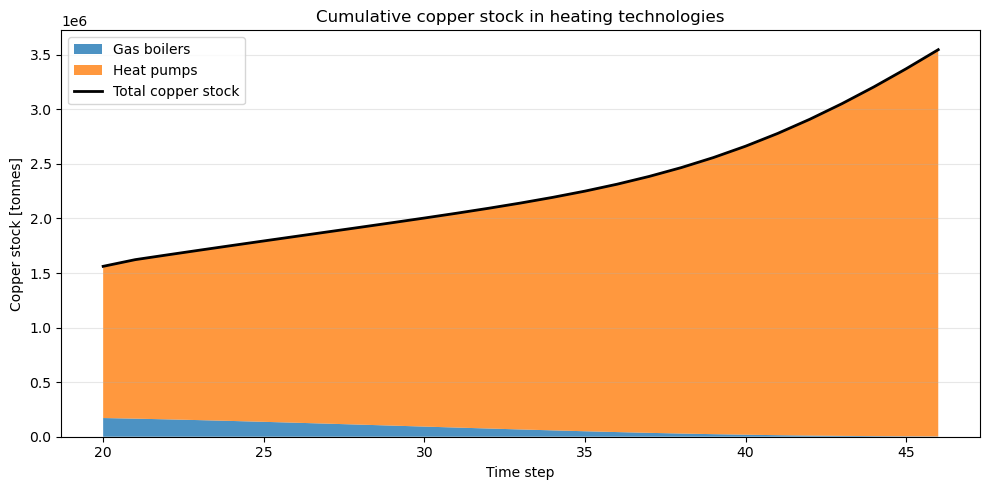

171.0 1615.0
1786000.0


In [ ]:
# Cummulative stock plot

t = np.arange(len(Copper_GB_s))
print(len(t))
print(len(Copper_HP_s[13:-1]))

total_cu_stock = Copper_GB_s + Copper_HP_s[13:-1]

plt.figure(figsize=(10, 5))

plt.stackplot(
    t[20:],
    Copper_GB_s[20:],
    Copper_HP_s[33:-1],
    labels=["Gas boilers", "Heat pumps"],
    alpha=0.8
)

plt.plot(
    t[20:],
    total_cu_stock[20:],
    color="black",
    linewidth=2,
    label="Total copper stock"
)

plt.xlabel("Time step")
plt.ylabel("Copper stock [tonnes]")
plt.title("Cumulative copper stock in heating technologies")

plt.legend(loc="upper left")
plt.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

#Reality check: in 2024 there are 114000 GB x 
copper_HP= 25 #kg
copper_GB= 1.5 #kg

gb_stock = 1.5 * 380000*0.3
hp_stock = 25 * 380000*0.17
tot_stock =  gb_stock + hp_stock
print(gb_stock/1000, hp_stock/1000)
print(tot_stock)



# FUNCTION TO RECALCULATE KPI 

In [78]:
# Analyse de sensibilité 
# Function to recalculate KPI 

def compute_kpis(COP_value, e_elec_value, efficiency_GB_value, e_gas_boiler_value):
 
  """ 
  Returns a dictionary with:
  - CO2_HP_base_cum: cumulative HP emissions (baseline scenario) 2024 2050 [tCO2]
  - CO2_HP_inc_cum: cumulative HP emissions (incentive scenario) 2024 2050 [tCO2]
  - CO2_GB_cum: cumulative emissions from gas boilers 2024 2050 [tCO2]

  """

  # DATA OF OUR MODEL 

  Years_HP = np.array(HP_DSM.t)                 #  1990–2050 
  HP_stock_base = np.array(HP_DSM.s)           
  HP_stock_inc  = np.array(HP_DSM_incentive.s)
  HP_in_base = np.array(HP_DSM.i)              # inflow HP baseline (nouvelles HP/an)
  HP_in_inc  = np.array(HP_DSM_incentive.i)    # inflow HP incitation

  
  years_GB_full = np.array(GB_DSM.t)           # Gas Boiler Years (2004–2050)
  GB_stock_full = np.array(GB_DSM.s)           # stock of GB 
  Years_GB = years_GB_full[20:]
  GB_stock = GB_stock_full[20:]

  # CALCULATION 

  elec_need_HP_per_house = S_household * cons_surface / COP_value

  Elec_imports_base = HP_stock_base * elec_need_HP_per_house / 1e6
  Elec_imports_inc  = HP_stock_inc  * elec_need_HP_per_house / 1e6

  # Emissions of HP AND GB [tCO2/an]
  
  CO2_HP_base = Elec_imports_base * 1000 * e_elec_value + HP_in_base * e_HP_manufacture
  CO2_HP_inc  = Elec_imports_inc  * 1000 * e_elec_value + HP_in_inc  * e_HP_manufacture

  CO2_GB_series = S_household*cons_surface / efficiency_GB_value * GB_stock * 3.6 * e_gas_boiler_value / 1000 #tCO2/year  # [tCO2/an]


  # Cumuls 2024–2050 

  mask_HP = Years_HP >= 2024
  mask_GB = Years_GB >= 2024

  CO2_HP_base_cum  = CO2_HP_base[mask_HP].sum()
  CO2_HP_inc_cum   = CO2_HP_inc[mask_HP].sum()
  CO2_GB_cum       = CO2_GB_series[mask_GB].sum()



  return {
    "CO2_HP_base_cum":  CO2_HP_base_cum,
    "CO2_HP_inc_cum":   CO2_HP_inc_cum,
    "CO2_GB_cum":       CO2_GB_cum,
  }

# Verifier si ca marche bien avec nos valeurs puis enlever tout ce qui est en bas 
res_base = compute_kpis(
  COP_value=COP,
  e_elec_value=e_elec,
  efficiency_GB_value=efficiency_GB,
  e_gas_boiler_value=e_gas_boiler
)

print("=== KPI de base avec les paramètres actuels ===")
print(f"CO2 HP baseline (2024 2050)   : {res_base['CO2_HP_base_cum']:.0f} tCO2")
print(f"CO2 HP incitation (2024 2050) : {res_base['CO2_HP_inc_cum']:.0f} tCO2")
print(f"CO2 chaudières gaz (2024 2050): {res_base['CO2_GB_cum']:.0f} tCO2")



=== KPI de base avec les paramètres actuels ===
CO2 HP baseline (2024 2050)   : 164546723 tCO2
CO2 HP incitation (2024 2050) : 412574747 tCO2
CO2 chaudières gaz (2024 2050): 1151858 tCO2


# SENSIBILITY ANALYSE (one-at-a-time) and after that I HAVE TO DO MINI MONTE CARLO


In [80]:
def sensitivity_param(param_name, base_value, values_to_test):
    
    print(f"\nSensibility in function of: {param_name}")
    print(f"Base Value : {base_value:.4f}")
    print(f"Tested values : {', '.join(f'{v:.4f}' for v in values_to_test)}")

    
    results = []

    for val in values_to_test:
        # to change the god parameter 
        COP_test           = COP           if param_name != "COP"           else val
        efficiency_GB_test = efficiency_GB if param_name != "efficiency_GB" else val
        e_elec_test        = e_elec        if param_name != "e_elec"        else val
        e_gas_test         = e_gas_boiler  if param_name != "e_gas_boiler"  else val

        res = compute_kpis(COP_test, e_elec_test, efficiency_GB_test, e_gas_test)
        results.append((val, res))

    # TRUE KPI
    base_res = None
    for (val, res) in results:
        if abs(val - base_value) < 1e-9:
            base_res = res
            break

    if base_res is None:
        print("Warning: No value is the true base value.")
        return None
    
    CO2_base_HP_inc  = base_res["CO2_HP_inc_cum"]
    CO2_base_HP      = base_res["CO2_HP_base_cum"]
    CO2_base_GB      = base_res["CO2_GB_cum"]

    
    print("\nValue\t\tCO2_HP_inc (tCO2)\tΔ vs base\tCO2_HP_base (tCO2)\tΔ vs base\tCO2_GB (tCO2)\tΔ vs base")

    values_list       = []
    CO2_HP_inc_list   = []
    CO2_HP_base_list  = []
    CO2_GB_list       = []
    d_inc_list        = []
    d_base_list       = []
    d_GB_list         = []

    for (val, res) in results:
        CO2_HP_inc_cum = res["CO2_HP_inc_cum"]
        CO2_HP_cum     = res["CO2_HP_base_cum"]
        CO2_GB_cum     = res["CO2_GB_cum"]

        d_inc  = 100 * (CO2_HP_inc_cum  - CO2_base_HP_inc) / CO2_base_HP_inc  if CO2_base_HP_inc  != 0 else 0.0
        d_base = 100 * (CO2_HP_cum      - CO2_base_HP)     / CO2_base_HP      if CO2_base_HP      != 0 else 0.0
        d_GB   = 100 * (CO2_GB_cum      - CO2_base_GB)     / CO2_base_GB      if CO2_base_GB      != 0 else 0.0

        print(f"{val:.4f}\t{CO2_HP_inc_cum:12.0f}\t{d_inc:+6.1f} %\t"
              f"{CO2_HP_cum:12.0f}\t{d_base:+6.1f} %\t"
              f"{CO2_GB_cum:12.0f}\t{d_GB:+6.1f} %")

        
        values_list.append(val)
        CO2_HP_inc_list.append(CO2_HP_inc_cum)
        CO2_HP_base_list.append(CO2_HP_cum)
        CO2_GB_list.append(CO2_GB_cum)
        d_inc_list.append(d_inc)
        d_base_list.append(d_base)
        d_GB_list.append(d_GB)

    
    return {
        "param": param_name,
        "base_value": base_value,
        "values": values_list,
        "CO2_HP_inc": CO2_HP_inc_list,
        "CO2_HP_base": CO2_HP_base_list,
        "CO2_GB": CO2_GB_list,
        "d_CO2_HP_inc": d_inc_list,
        "d_CO2_HP_base": d_base_list,
        "d_CO2_GB": d_GB_list,
    }



factors = [0.8, 1.0, 1.2]

# Sensibility of parameters 
#  
COP_values = [f * COP for f in factors]
sens_COP= sensitivity_param("COP", COP, COP_values)

e_elec_values = [f * e_elec for f in factors]
sens_elec = sensitivity_param("e_elec", e_elec, e_elec_values)

eff_GB_values = [f * efficiency_GB for f in factors]
sens_effGB = sensitivity_param("efficiency_GB", efficiency_GB, eff_GB_values)

e_gas_values = [f * e_gas_boiler for f in factors]
sens_gas = sensitivity_param("e_gas_boiler", e_gas_boiler, e_gas_values)



Sensibility in function of: COP
Base Value : 3.2600
Tested values : 2.6080, 3.2600, 3.9120

Value		CO2_HP_inc (tCO2)	Δ vs base	CO2_HP_base (tCO2)	Δ vs base	CO2_GB (tCO2)	Δ vs base
2.6080	   412611663	  +0.0 %	   164561522	  +0.0 %	     1151858	  +0.0 %
3.2600	   412574747	  +0.0 %	   164546723	  +0.0 %	     1151858	  +0.0 %
3.9120	   412550137	  -0.0 %	   164536858	  -0.0 %	     1151858	  +0.0 %

Sensibility in function of: e_elec
Base Value : 0.0273
Tested values : 0.0218, 0.0273, 0.0328

Value		CO2_HP_inc (tCO2)	Δ vs base	CO2_HP_base (tCO2)	Δ vs base	CO2_GB (tCO2)	Δ vs base
0.0218	   412545215	  -0.0 %	   164534885	  -0.0 %	     1151858	  +0.0 %
0.0273	   412574747	  +0.0 %	   164546723	  +0.0 %	     1151858	  +0.0 %
0.0328	   412604280	  +0.0 %	   164558562	  +0.0 %	     1151858	  +0.0 %

Sensibility in function of: efficiency_GB
Base Value : 0.9000
Tested values : 0.7200, 0.9000, 1.0800

Value		CO2_HP_inc (tCO2)	Δ vs base	CO2_HP_base (tCO2)	Δ vs base	CO2_GB (tCO2)	Δ vs base
0.7200

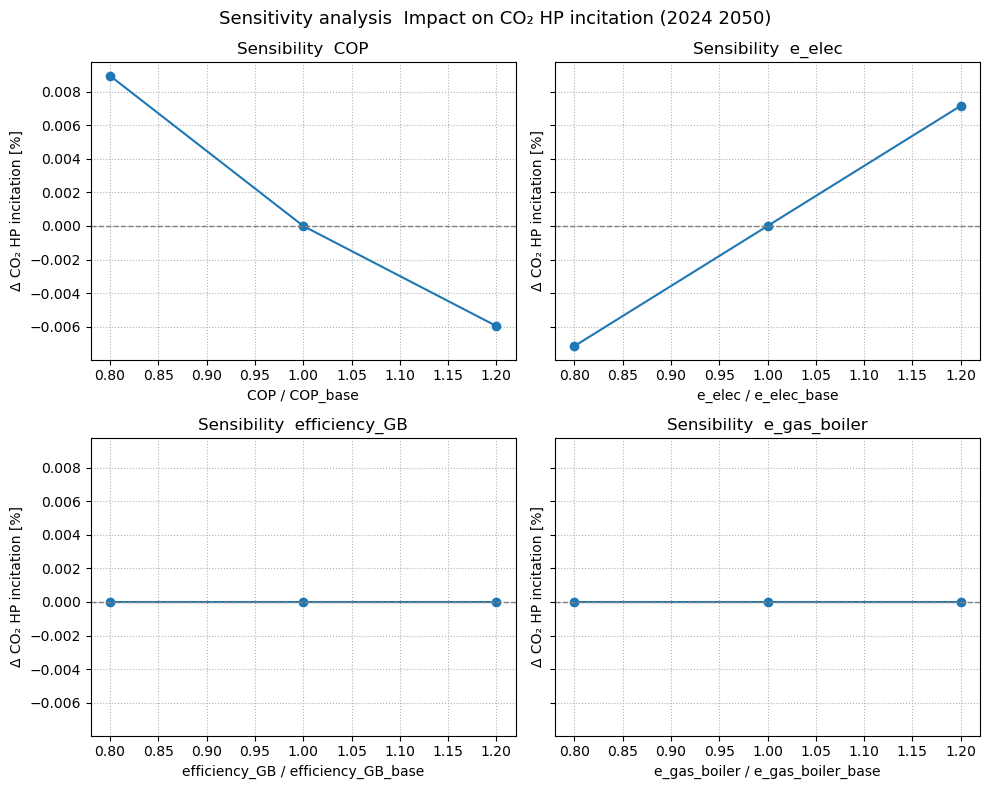

In [81]:
all_sens = [sens_COP, sens_elec, sens_effGB, sens_gas]

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
axes = axes.flatten()

for ax, sens in zip(axes, all_sens):
    param_name = sens["param"]
    base_val   = sens["base_value"]
    x_values   = np.array(sens["values"]) / base_val     # normalisation (0.8, 1.0, 1.2)
    y_rel      = sens["d_CO2_HP_inc"]                    # Δ CO2 HP incitation [%]

    ax.plot(x_values, y_rel, marker="o")
    ax.axhline(0, color="grey", linestyle="--", linewidth=1)
    ax.grid(True, linestyle=":")

    ax.set_title(f"Sensibility  {param_name}")
    ax.set_xlabel(f"{param_name} / {param_name}_base")
    ax.set_ylabel("Δ CO₂ HP incitation [%]")

fig.suptitle("Sensitivity analysis  Impact on CO₂ HP incitation (2024 2050)", fontsize=13)
plt.tight_layout()
plt.show()




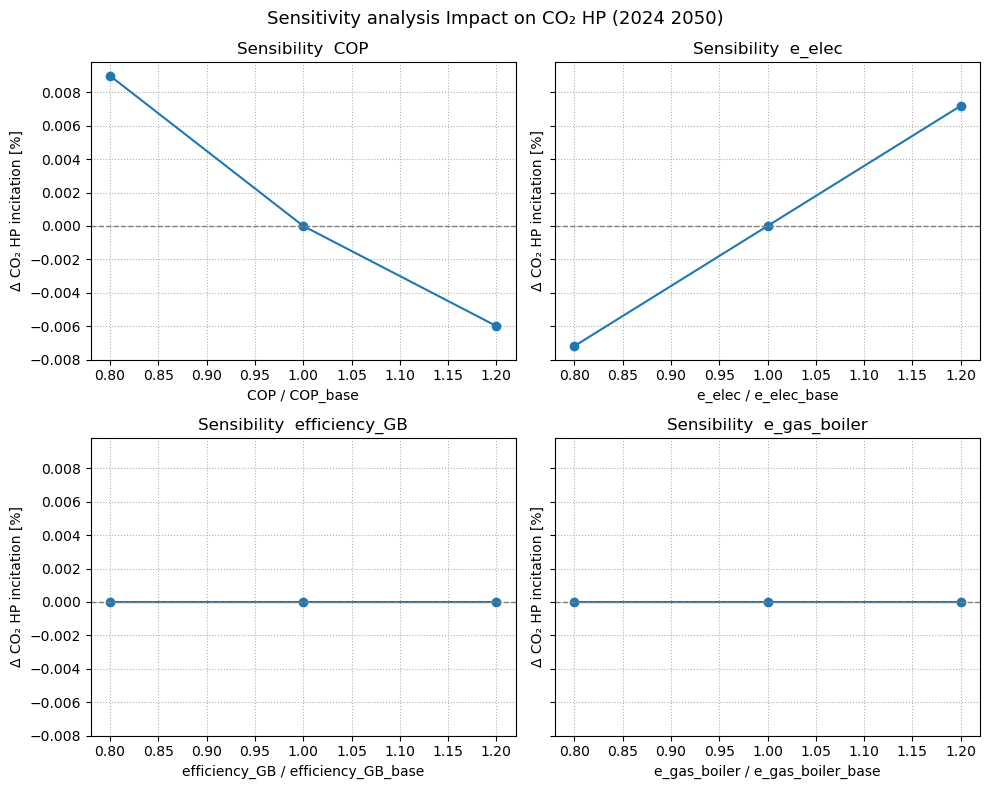

In [82]:
all_sens = [sens_COP, sens_elec, sens_effGB, sens_gas]

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
axes = axes.flatten()

for ax, sens in zip(axes, all_sens):
    param_name = sens["param"]
    base_val   = sens["base_value"]
    x_values   = np.array(sens["values"]) / base_val     # normalisation (0.8, 1.0, 1.2)
    y_rel      = sens["d_CO2_HP_base"]                    # Δ CO2 HP incitation [%]

    ax.plot(x_values, y_rel, marker="o")
    ax.axhline(0, color="grey", linestyle="--", linewidth=1)
    ax.grid(True, linestyle=":")

    ax.set_title(f"Sensibility  {param_name}")
    ax.set_xlabel(f"{param_name} / {param_name}_base")
    ax.set_ylabel("Δ CO₂ HP incitation [%]")

fig.suptitle("Sensitivity analysis Impact on CO₂ HP (2024 2050)", fontsize=13)
plt.tight_layout()
plt.show()

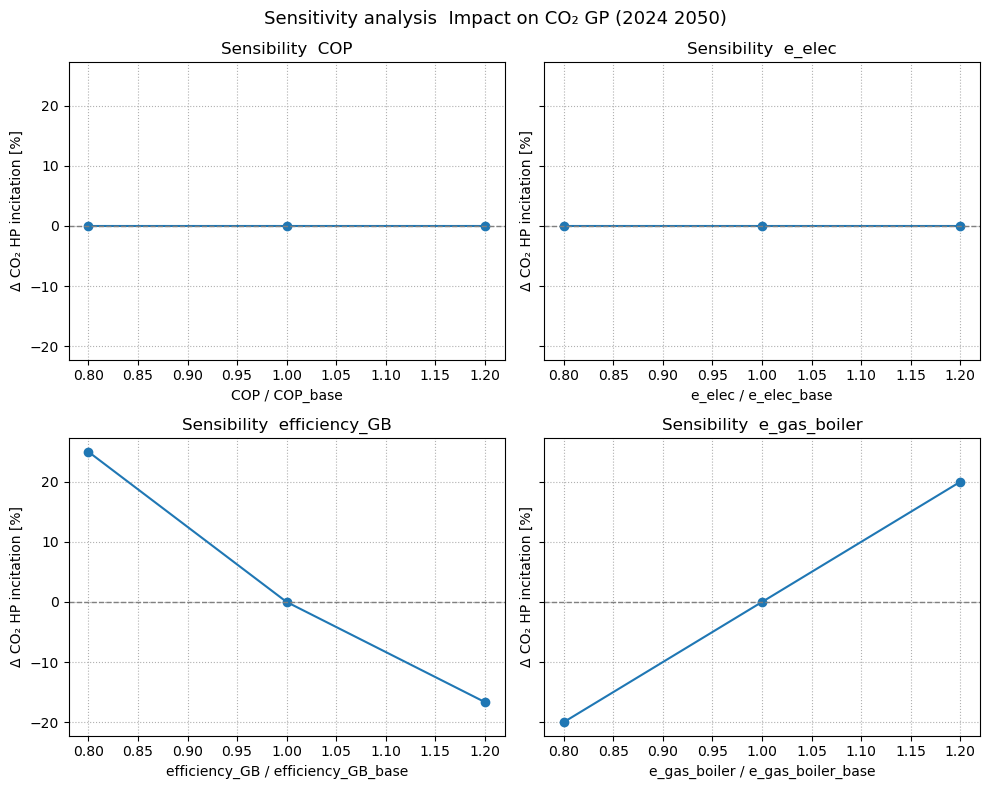

In [83]:
all_sens = [sens_COP, sens_elec, sens_effGB, sens_gas]

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
axes = axes.flatten()

for ax, sens in zip(axes, all_sens):
    param_name = sens["param"]
    base_val   = sens["base_value"]
    x_values   = np.array(sens["values"]) / base_val     # normalisation (0.8, 1.0, 1.2)
    y_rel      = sens["d_CO2_GB"]                    # Δ CO2 HP incitation [%]

    ax.plot(x_values, y_rel, marker="o")
    ax.axhline(0, color="grey", linestyle="--", linewidth=1)
    ax.grid(True, linestyle=":")

    ax.set_title(f"Sensibility  {param_name}")
    ax.set_xlabel(f"{param_name} / {param_name}_base")
    ax.set_ylabel("Δ CO₂ HP incitation [%]")

fig.suptitle("Sensitivity analysis  Impact on CO₂ GP (2024 2050)", fontsize=13)
plt.tight_layout()
plt.show()